In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt  
from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms as T



In [183]:
class AGMDS(D.Dataset):
    def __init__(self, df, week, transform=None, channels=[0,1,2]):
        self.week = week
        self.df = df
        self.root_path = "/home/user/michigan/data/AGM01/"
        self.channels = channels
        self.img_dir = self.root_path+self.week
        self.len = df.shape[0]
        self.transforms = transform
        self.label = df["Metadata_WellID_Nuclei"] 
        
    @staticmethod
    def _load_img_as_tensor(self, file_name):
        with Image.open(file_name) as img:
            img = img.resize((112,112),resample=Image.NEAREST)
            pixels = np.asarray(img)
            pixels = pixels.astype('float32')
            # Scale them to 0~1
#             left = int(len(pixels) / 10)
#             right = left*6
#             left = left*4
#             maxmum = pixels[left:right, left:right].max()
            maxmum = pixels.max()
            pixels = pixels / maxmum
            pixels = np.clip(pixels, 0, 1)
            return T.ToTensor()(pixels)

    def _get_img_path(self, index, channel):
        well, field, cell_idx = self.df.iloc[index]["Metadata_WellID_Nuclei"], self.df.iloc[index]["Metadata_FieldID_Nuclei"], self.df.iloc[index]["ObjectNumber_Nuclei"]
        return "/home/user/michigan/data/AGM01/Single_%s/%s_%s_%s_%s.tif" % (self.week, well, field, ("Ch" + str(channel)), cell_idx)
    
    def __getitem__(self, index):
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        img = torch.cat([self._load_img_as_tensor(self, img_path) for img_path in paths])
        return img, self.label[index]

    def __len__(self):
        return self.len

In [184]:
def show_image(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [48]:
csv_file = "/home/user/michigan/data/AGM/AGM_Metadata.csv"
meta_data = pd.read_csv(csv_file)
meta_data1 = meta_data[meta_data["Metadata_PlateID"]=="Week1_22123"]
meta_data1.pop("Group_Index")

# Metadata list for Week1_22123
## 60 class, B02~G11, DMSO as NC, taxol as PC.

In [189]:
meta_data1.drop_duplicates()

,Metadata_Image_Metadata_Compound,Metadata_Image_Metadata_Concentration,Metadata_PlateID,Metadata_WellID,COND
0,DMSO,0.000,Week1_22123,B02,NC
4,cytochalasin B,30.000,Week1_22123,B03,NaN
8,cytochalasin B,10.000,Week1_22123,B04,NaN
12,cytochalasin B,3.000,Week1_22123,B05,NaN
16,cytochalasin B,1.000,Week1_22123,B06,NaN
20,cytochalasin B,0.300,Week1_22123,B07,NaN
24,cytochalasin B,0.100,Week1_22123,B08,NaN
28,cytochalasin B,0.030,Week1_22123,B09,NaN
32,cytochalasin B,0.010,Week1_22123,B10,NaN
36,taxol,0.300,Week1_22123,B11,PC


In [3]:
week_list=["Week1_22123"]
Week1_22123_features = pd.read_csv("/home/user/michigan/data/AGM01/features/"+week_list[0]+"_Joined.csv")

In [105]:
Week1_22123_features["Metadata_WellID_Nuclei"].value_counts().sort_index(ascending=True)

B02    842
B03    240
B04    351
B05    296
B06    825
B07    832
B08    756
B09    765
B10    616
B11    187
C02    834
C03    369
C04    412
C05    428
C06    560
C07    617
C08    706
C09    703
C10    641
C11    154
D02    624
D03    199
D04    177
D05    142
D06    151
D07    167
D08     74
D09    246
D10    490
D11    184
E02    208
E03    203
E04    179
E05    184
E06    220
E07    246
E08    549
E09    580
E10    754
E11    670
F02    149
F03    544
F04    566
F05    608
F06    583
F07    694
F08    574
F09    697
F10    599
F11    774
G02    251
G03    374
G04    266
G05    305
G06    312
G07    423
G08    359
G09    349
G10    346
G11    831
Name: Metadata_WellID_Nuclei, dtype: int64

In [176]:
num = 8

idx_list = np.cumsum(list(Week1_22123_features["Metadata_WellID_Nuclei"].value_counts().sort_index(ascending=True)))
stack_site = []
cat_well = []
for i in range(10):
    stack_site = torch.stack([AGMData[idx_list[i]+j+0][0] for j in range(num)])
    cat_well.append(stack_site)
images = torch.cat(cat_well)


In [190]:
np.rand(0,10)

AttributeError: module 'numpy' has no attribute 'rand'

In [165]:
def show_image(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


Original images


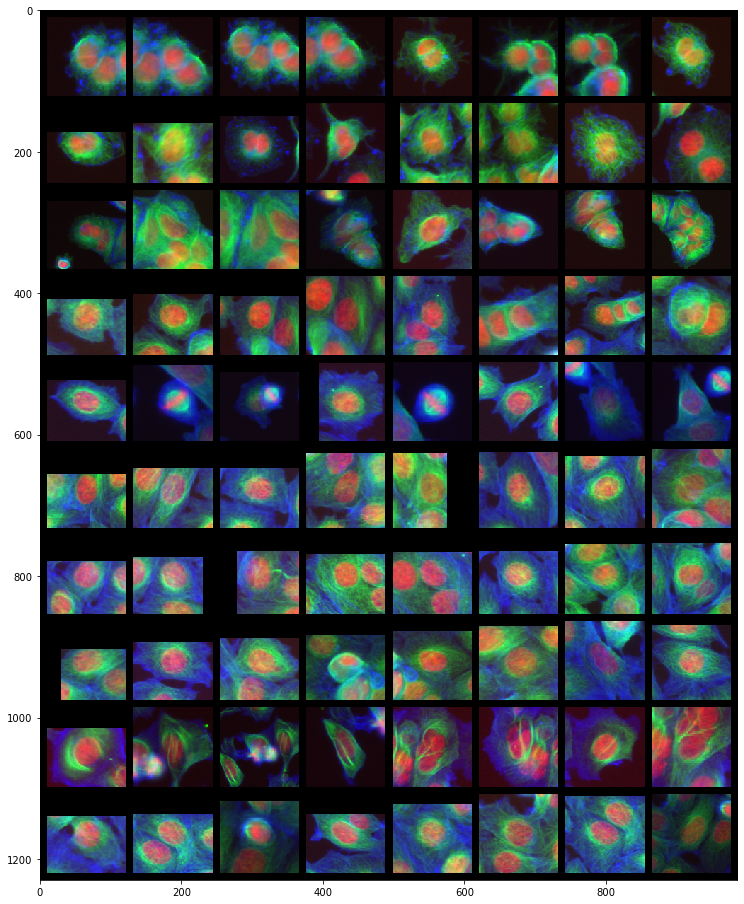

In [182]:
print('Original images')
plt.figure(figsize=(16, 16))
show_image(torchvision.utils.make_grid(images, 8, 10))
plt.savefig("a.png")
plt.show()


Original images


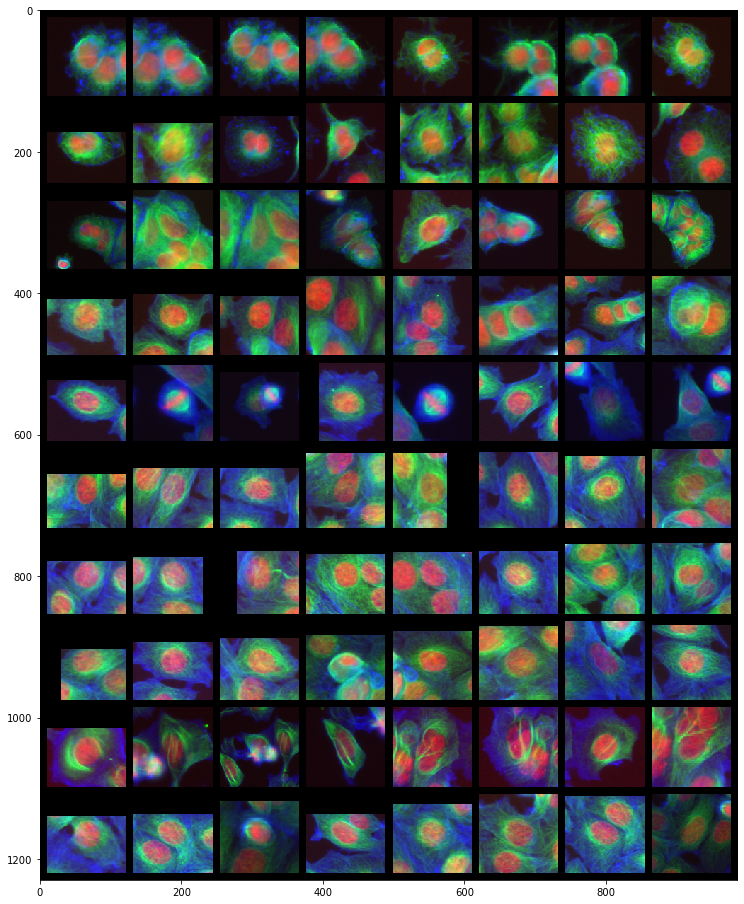

In [177]:
print('Original images')
plt.figure(figsize=(16, 16))
show_image(torchvision.utils.make_grid(images,8,10))
plt.show()

In [157]:
torch.cat([AGMData[idx_list[0]][0],AGMData[idx_list[1]][0],AGMData[idx_list[2]][0]]).shape

torch.Size([9, 112, 112])

In [68]:
AGMData = AGMDS(df = Week1_22123_features, week = week_list[0])
batch_size = 8
loader = D.DataLoader(AGMData, batch_size=batch_size, shuffle=True)

In [ ]:
loaderB02 = D.DataLoader(AGMData, batch_size=batch_size, shuffle=True)

In [143]:
image, label = iter(loader).next()

In [144]:
image.shape

torch.Size([8, 3, 112, 112])

Original images


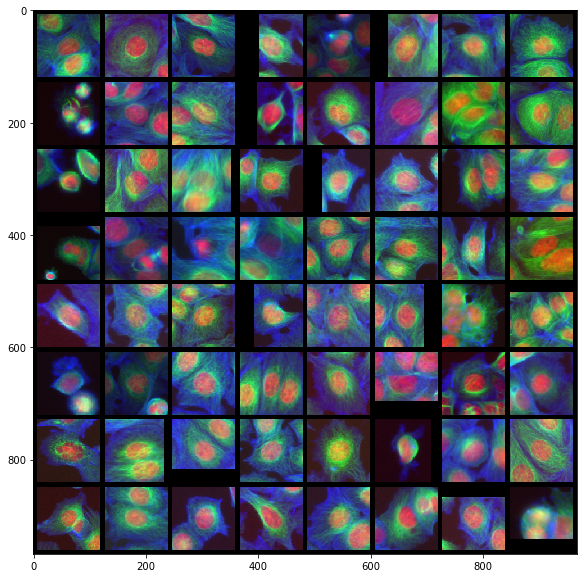

In [32]:
print('Original images')
plt.figure(figsize=(10, 10))
show_image(torchvision.utils.make_grid(images,8,8))
plt.show()

In [191]:
pd.read_csv("code_data300.csv")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,64
0,0,-0.479754,0.610989,1.145984,0.786013,-0.511028,0.127203,-0.680227,-0.929334,-1.081217,...,0.066255,1.267859,1.239507,0.253421,-0.065257,-0.349919,1.726328,-1.950024,2.639491,E09
1,1,-2.981777,-0.507157,-0.845673,2.345851,-0.944530,1.376561,-0.020400,-1.047183,-0.513524,...,-0.462247,-1.964078,-1.586555,0.539832,-0.182947,-0.546170,0.107781,-0.395579,1.356600,C04
2,2,-2.212343,2.005947,-0.482693,1.776733,0.590419,-0.710306,-0.974129,2.119795,-0.755698,...,-0.119841,0.487164,-0.697542,0.479299,0.902424,1.471033,0.630338,0.679845,1.052341,F10
3,3,-1.420297,0.424601,-0.778026,0.046591,1.433553,-0.710319,-0.196093,-0.373150,-0.907873,...,0.213779,-2.169371,1.621670,2.059408,1.472955,-0.182057,1.326515,-1.568914,-0.588182,F02
4,4,0.929104,-0.987298,0.245628,1.380840,0.970126,-1.806189,0.484493,1.316277,-0.356196,...,-0.376835,-1.063377,0.392168,-0.462168,-0.123798,-0.444095,0.323701,-0.710225,0.796728,C02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24075,75,0.531510,-0.272568,-0.200523,-0.231049,0.369814,-0.503963,0.757477,0.279059,-0.621790,...,-1.783679,-1.187941,-0.558779,0.587221,0.005660,-0.101512,0.370353,1.323296,-0.150348,G03
24076,76,-0.923815,0.626022,0.545943,-1.356914,0.199019,-0.420479,-0.946897,-0.096543,-1.089700,...,1.381512,1.745100,-0.780837,0.554433,1.263737,1.216425,-1.438184,-1.261113,0.419633,G11
24077,77,-0.290341,-0.492679,1.190586,-0.740257,-0.134001,0.119671,0.558336,-0.926060,-0.472805,...,0.876035,-0.819114,-0.082745,-0.292876,0.371417,0.832764,0.221220,0.090787,-0.919770,D02
24078,78,-0.193659,-0.132860,-1.707669,1.215339,-1.139395,0.076286,-0.194794,0.512166,-0.193601,...,1.311760,-0.897662,-0.526259,0.017912,0.123856,0.336981,0.448273,-0.638908,-1.127497,B07


## Sample test

In [8]:
Week1_22123_features = pd.read_csv("/home/user/michigan/data/AGM/features/Week1_22123_Joined.csv")

In [9]:
df = Week1_22123_features

In [18]:
def get_img_path(index, channel):
    well, field, cell_idx = df.iloc[index]["Metadata_WellID_Nuclei"], df.iloc[index]["Metadata_FieldID_Nuclei"],df.iloc[index]["ObjectNumber_Nuclei"]
    path = "/home/user/michigan/data/AGM01/Single_%s/%s_%s_%s_%s.tif" % ("Week1_22123", well, field, ("Ch" + str(channel)), cell_idx)
    return path 

def load_img_as_tensor(file_name):
    img = Image.open(file_name)
    
    img= img.resize((110,110))
    return T.ToTensor()(img)

def show_images(name_list):
    plt.figure(figsize=(16, 16))
    
    for i in range(len(name_list)):
        img = Image.open(name_list[i],"r")
        plt.subplot(1,3,i+1)
        plt.imshow(img, cmap="gray")
    plt.show()

In [22]:
paths=[get_img_path(2,ch) for ch in [0,1,2]]

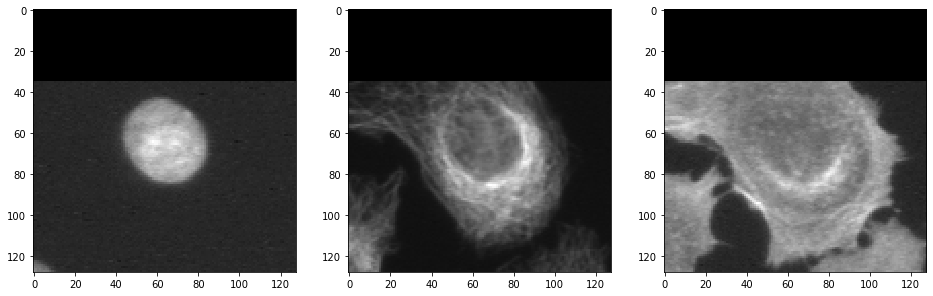

In [24]:
show_images(paths)

In [170]:
img1 = Image.open(paths[0])
img2 = Image.open(paths[1])
img3 = Image.open(paths[2])

In [196]:
def con(npimg1):
    npimg1 = npimg1.resize((112,112),resample=Image.NEAREST)    
    npimg1 = np.asarray(npimg1)
    
    left = int(len(npimg1) / 4)
    right = left*3
    maxmum = npimg1[left:right, left:right].max()
    npimg1 = npimg1.astype('float')
    return npimg1 / maxmum

In [193]:
plt.imshow(np.transpose(np.array([con(img1), con(img2), con(img3)]), (1, 2, 0)))

NameError: name 'con' is not defined

In [182]:
npimg1.shape[0]

128

In [191]:
len(npimg1)

128

In [188]:
npimg1[20:100, 20:100].shape

(80, 80)

In [190]:
112/4

28.0